# Wstęp

Wykonaj i przeanalizuj poniższy skrypt

iris:  (150, 4)
digits:  (1797, 64)
diabetes:  (442, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Etykieta cyfry:  7


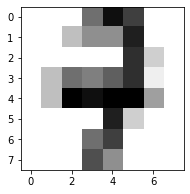

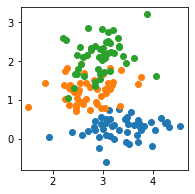

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import random
import numpy as np

iris = datasets.load_iris()
digits = datasets.load_digits()
diabetes = datasets.load_diabetes()

print("iris: ", iris.data.shape) # macierz rozmiaru (liczba próbek, liczba cech)
print("digits: ", digits.data.shape)
print("diabetes: ", diabetes.data.shape)

print(iris.target)

digit_idx = 43

print("Etykieta cyfry: ", digits.target[digit_idx])

# wyświetlenie przykładowego obrazu
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[digit_idx], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

def disturb_data(X, sigma):
  return X + sigma * np.random.randn(*(X.shape))

plt.figure(1, figsize=(3, 3))
iris_reduced_data = disturb_data(iris.data[:, [1,3]], 0.3)
for d_range in [range(0, 49), range(50, 99), range(100, 149)]:
    plt.scatter(iris_reduced_data[d_range, 0], iris_reduced_data[d_range, 1])
plt.show()


# Zadanie 1

Policz ile jest próbek w poszczególnych klasach

In [2]:
dataset = digits
counts = dict()
for cls in dataset.target:
  if cls in counts:
    counts[cls] += 1
  else:
    counts[cls] = 1

print(counts)

{0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


# Zadanie 2

Podziel zbiór danych `iris_reduced_data` na dwie części: część treningowa (po 40 osobników z każdej klasy) i testowa (po 10 osobników  każdej klasy)
Naucz klasyfikator $k$NN ($k$ Nearest Neighbors) klasyfikować dane z zestawu `iris_reduced_data` (funkcja `fit` korzystająca z części treningowej.
Policz (korzystając z części testowej):

*   Dokładność (accuracy)
*   Czułość (sensitivity, true positive rate, TPR)
*   Swoistość (specificity, true negative rate, TNR)

Jak zmienią się te wskaźniki gdy weźmiemy tylko po 30 osobników z każdej klasy do zbioru treningowego?

Uwaga: TPR i TNR dla klasyfikacji wieloklasowej definiujemy tu jako średnią z wartości, odpowiednio TPR i TNR, dla klasyfikacji binarnej w formie "1 vs all", czyli sprowadzamy do klasyfikacji binarnej czy próbka należy do określonej klasy czy nie.


ACC =  0.92
AUC =  0.9531772575250834
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       0.87      0.87      0.87        23
           2       0.91      0.87      0.89        23

    accuracy                           0.92        75
   macro avg       0.92      0.91      0.91        75
weighted avg       0.92      0.92      0.92        75

[[[45  1]
  [ 0 29]]

 [[49  3]
  [ 3 20]]

 [[50  2]
  [ 3 20]]]


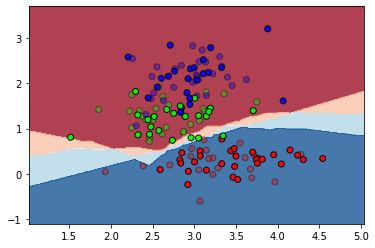

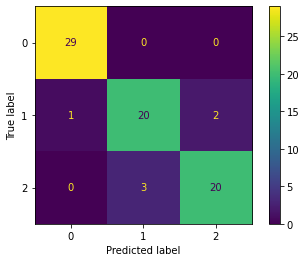

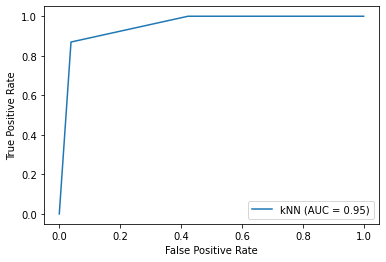

In [3]:
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


neigh = KNeighborsClassifier(n_neighbors=3)

X_train, X_test, y_train, y_test = train_test_split(
    iris_reduced_data, iris.target, test_size=0.50, random_state=42)
neigh.fit(X_train, y_train)

clf = neigh
X = iris_reduced_data
h = .01  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
class_number = 0
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, class_number]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax = plt.subplot()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
            edgecolors='k', alpha=0.4)
# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
            edgecolors='k', alpha=0.9)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

y_pred = neigh.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
print("ACC = ", metrics.accuracy_score(y_test, y_pred))
print("AUC = ", metrics.auc(fpr, tpr))
print(metrics.classification_report(y_test, y_pred))
print(metrics.multilabel_confusion_matrix(y_test, y_pred))
metrics.plot_confusion_matrix(clf, X_test, y_test)

roc_auc = metrics.auc(fpr, tpr)
roc_plot = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="kNN")
roc_plot.plot()


# Zadanie 3

Powtórz zadanie 2, ale dla klasyfikatora SVM. Użyj kerneli `rbf` i `linear`. Porównaj działanie dla wartości parametru `C=1.0, 100.0, 0.01`. Dla kernela `rbf` przetestuj różne opcje skalowania cech (parametr `gamma`: wartosci `scale`, `auto`, `1.0`, `10.0`, `0.1`.

In [4]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
for C in [1.0, 100.0, 0.01]:
  clf.set_params(C=C, kernel='linear')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("ACC [linear, C=", C, "] = ", metrics.accuracy_score(y_test, y_pred))
  clf.kernel = 'rbf'
  for gamma in ['scale', 'auto', 1.0, 10.0, 0.1]:
    clf.set_params(C=C, kernel='rbf', gamma=gamma)
    clf.fit(X_train, y_train)
    print("ACC [rbf, C=", C, ", gamma=", gamma, "] = ", metrics.accuracy_score(y_test, y_pred))





ACC [linear, C= 1.0 ] =  0.8933333333333333
ACC [rbf, C= 1.0 , gamma= scale ] =  0.8933333333333333
ACC [rbf, C= 1.0 , gamma= auto ] =  0.8933333333333333
ACC [rbf, C= 1.0 , gamma= 1.0 ] =  0.8933333333333333
ACC [rbf, C= 1.0 , gamma= 10.0 ] =  0.8933333333333333
ACC [rbf, C= 1.0 , gamma= 0.1 ] =  0.8933333333333333
ACC [linear, C= 100.0 ] =  0.8666666666666667
ACC [rbf, C= 100.0 , gamma= scale ] =  0.8666666666666667
ACC [rbf, C= 100.0 , gamma= auto ] =  0.8666666666666667
ACC [rbf, C= 100.0 , gamma= 1.0 ] =  0.8666666666666667
ACC [rbf, C= 100.0 , gamma= 10.0 ] =  0.8666666666666667
ACC [rbf, C= 100.0 , gamma= 0.1 ] =  0.8666666666666667
ACC [linear, C= 0.01 ] =  0.5466666666666666
ACC [rbf, C= 0.01 , gamma= scale ] =  0.5466666666666666
ACC [rbf, C= 0.01 , gamma= auto ] =  0.5466666666666666
ACC [rbf, C= 0.01 , gamma= 1.0 ] =  0.5466666666666666
ACC [rbf, C= 0.01 , gamma= 10.0 ] =  0.5466666666666666
ACC [rbf, C= 0.01 , gamma= 0.1 ] =  0.5466666666666666


# Zadanie 4

Znajdź najlepsze (pod względem dokładności) parametry klasyfikatora SVM z użyciem 5-krotnej walidacji krzyżowej: kernel, $C$, wybrany parametr kernela. Przeszukaj przynajmniej 100 zestawów wartości.

Czy te same parametry zapewniają najlepszą wartość innych metryk?

Wykorzystaj `from sklearn.model_selection import KFold`

In [5]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC

def evaluate_classifier(C):
  kf = KFold(n_splits=5)
  X = iris_reduced_data
  y = iris.target
  for train_index, test_index in kf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = SVC(gamma='auto', kernel='rbf', C=C)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred))


for C in [1.0, 3.0, 0.3]:
  print(f"C = {C}")
  evaluate_classifier(C)

C = 1.0
0.9333333333333333
0.9333333333333333
0.6333333333333333
0.8
0.7
C = 3.0
0.9333333333333333
0.9333333333333333
0.6666666666666666
0.8
0.7
C = 0.3
0.9
0.8666666666666667
0.6333333333333333
0.8
0.7
